![PySpark](images/pyspark.jpeg)

# Spark Session - Local Cluster
 - One new param! spark.sql.execution.arrow.enabled  

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark Demo") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .getOrCreate()

In [5]:
# from pyspark.sql.types import *
from pyspark.sql.functions import col, rand

# Make some dummy data
df = spark.range(0, 1000 * 1000).withColumn('id', (col('id') / 10000).cast('integer')).withColumn('v', rand())
df.show(5)

+---+-------------------+
| id|                  v|
+---+-------------------+
|  0| 0.5766208283479304|
|  0|0.49919833268384617|
|  0|  0.791001313320162|
|  0| 0.5887932034147858|
|  0|   0.75336157801217|
+---+-------------------+
only showing top 5 rows



# Simple Python UDF (x+1)

![python_udf](images/python_udf.png)

In [23]:
from pyspark.sql.functions import udf, count

@udf('double')
def plus_one(v):
    return v + 1

df.withColumn('v_plus1', plus_one(df.v)).show(5)

+---+-------------------+------------------+
| id|                  v|           v_plus1|
+---+-------------------+------------------+
|  0| 0.5766208283479304|1.5766208283479304|
|  0|0.49919833268384617| 1.499198332683846|
|  0|  0.791001313320162|1.7910013133201619|
|  0| 0.5887932034147858|1.5887932034147858|
|  0|   0.75336157801217|  1.75336157801217|
+---+-------------------+------------------+
only showing top 5 rows



In [37]:
# Timing.  Including aggregation to avoid optimising out the UDF calculation.
plus_one_results = %timeit -o -n5 -r1 df.withColumn('v_plus1', plus_one(df.v)).agg(count(col('v_plus1'))).show()

+--------------+
|count(v_plus1)|
+--------------+
|       1000000|
+--------------+

+--------------+
|count(v_plus1)|
+--------------+
|       1000000|
+--------------+

+--------------+
|count(v_plus1)|
+--------------+
|       1000000|
+--------------+

+--------------+
|count(v_plus1)|
+--------------+
|       1000000|
+--------------+

+--------------+
|count(v_plus1)|
+--------------+
|       1000000|
+--------------+

456 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


# Pandas UDF Equivalent (x+1)
 - Default is mode is PandasUDFType.SCALAR

![pandas_udf](images/pandas_scalar_udf.png)

In [20]:
from pyspark.sql.functions import pandas_udf

@pandas_udf("double")
def pandas_plus_one(v):
    return v + 1

df.withColumn('v_plus1', pandas_plus_one(df.v)).show(5)

+--------+
|count(v)|
+--------+
| 1000000|
+--------+



In [38]:
pandas_plus_one_results = %timeit -o -n5 -r1 df.withColumn('v_plus1', pandas_plus_one(df.v)).agg(count(col('v_plus1'))).show()

+--------------+
|count(v_plus1)|
+--------------+
|       1000000|
+--------------+

+--------------+
|count(v_plus1)|
+--------------+
|       1000000|
+--------------+

+--------------+
|count(v_plus1)|
+--------------+
|       1000000|
+--------------+

+--------------+
|count(v_plus1)|
+--------------+
|       1000000|
+--------------+

+--------------+
|count(v_plus1)|
+--------------+
|       1000000|
+--------------+

323 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


# More Meaningful Example
 - Vectorised operations == SPEED!

# UDF example:

In [43]:
import pandas as pd
from scipy import stats

@udf('double')
def cdf(v):
    # stats.norm.cdf works on ints, lists, Pandas Series and NumPy arrays
    return float(stats.norm.cdf(v))

df.withColumn('cumulative_probability', cdf(df.v)).show(5)

+---+-------------------+----------------------+
| id|                  v|cumulative_probability|
+---+-------------------+----------------------+
|  0| 0.5766208283479304|    0.7179021870801072|
|  0|0.49919833268384617|    0.6911801654655783|
|  0|  0.791001313320162|    0.7855283874473473|
|  0| 0.5887932034147858|    0.7219999971499573|
|  0|   0.75336157801217|    0.7743836676693137|
+---+-------------------+----------------------+
only showing top 5 rows



In [47]:
# Timing
cdf_results = %timeit -o -n3 -r1 df.withColumn('cumulative_probability', cdf(df.v)).agg(count(col('cumulative_probability'))).show()

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                      1000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                      1000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                      1000000|
+-----------------------------+

19.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


# Pandas UDF Example
 - Uses NumPy for CDF operation on an array instead of one number per function call

In [48]:
import pandas as pd
from scipy import stats

# returnType=PandasUDFType.SCALAR is implied
@pandas_udf('double')
def pandas_cdf(v):
    return pd.Series(stats.norm.cdf(v))

df.withColumn('cumulative_probability', pandas_cdf(df.v)).show(5)

+---+-------------------+----------------------+
| id|                  v|cumulative_probability|
+---+-------------------+----------------------+
|  0| 0.5766208283479304|    0.7179021870801072|
|  0|0.49919833268384617|    0.6911801654655783|
|  0|  0.791001313320162|    0.7855283874473473|
|  0| 0.5887932034147858|    0.7219999971499573|
|  0|   0.75336157801217|    0.7743836676693137|
+---+-------------------+----------------------+
only showing top 5 rows



In [49]:
# Timing
pandas_cdf_results = %timeit -o -n5 -r1 df.withColumn('cumulative_probability', pandas_cdf(df.v)).agg(count(col('cumulative_probability'))).show()

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                      1000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                      1000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                      1000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                      1000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                      1000000|
+-----------------------------+

385 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


<Figure size 720x720 with 0 Axes>

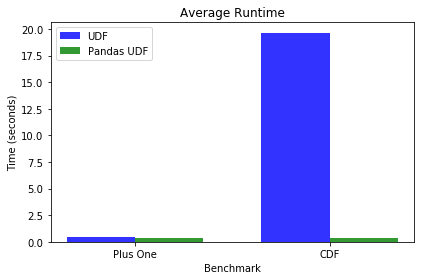

In [59]:
import numpy as np
import matplotlib.pyplot as plt

n_groups = 2
udf_data = (plus_one_results.average, cdf_results.average)
pudf_data = (pandas_plus_one_results.average, pandas_cdf_results.average)

plt.figure(figsize=(10,10))

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, udf_data, bar_width,
alpha=opacity,
color='b',
label='UDF')

rects2 = plt.bar(index + bar_width, pudf_data, bar_width,
alpha=opacity,
color='g',
label='Pandas UDF')

plt.xlabel('Benchmark')
plt.ylabel('Time (seconds)')
plt.title('Average Runtime')
plt.xticks(index + bar_width/2, ('Plus One', 'CDF'))
plt.legend()

plt.tight_layout()
plt.savefig('images/benchmarks.png', dpi=300)

plt.show()

![benchmarks_plot](images/benchmarks.png)

# Pandas UDF Grouped Map
 - Here's where it gets interesting...
 - Pandas DataFrame input, Pandas DataFrame output

![grouped_map](images/pandas_grouped_map_udf.png)

In [66]:
from pyspark.sql.functions import pandas_udf, PandasUDFType

df = spark.createDataFrame(
    [(0, 2.3, "apple"),
     (1, 1.0, "apple"),
     (2, 5.1, "orange"),
     (3, 6.5, "apple"),
     (4, 3.5, "orange"),
     (5, 6.4, "apple")],
    ("id", "value", "fruit"))

@pandas_udf("id long, value double, norm double, fruit string", PandasUDFType.GROUPED_MAP)
def normalize(pdf):
    v = pdf.value
    return pdf.assign(norm=(v - v.mean()) / v.std())

df.groupby("fruit").apply(normalize).show()

+---+-----+-------------------+------+
| id|value|               norm| fruit|
+---+-----+-------------------+------+
|  2|  5.1| 0.7071067811865475|orange|
|  4|  3.5|-0.7071067811865475|orange|
|  0|  2.3|-0.6201412226583429| apple|
|  1|  1.0|-1.0808175594902545| apple|
|  3|  6.5| 0.8681977117216795| apple|
|  5|  6.4| 0.8327610704269172| apple|
+---+-----+-------------------+------+



# TODO:
 - Make a UDF equivalent of the grouped map.
 - Add to the benchmark plot
 - Benchmark Koalas too, better examples

# Koalas
 - Pandas like distributed DataFrame for Spark
 - Easy installation (Pip or Conda)
 - Incomplete but very active

In [68]:
!pip install koalas

     |████████████████████████████████| 184kB 1.3MB/s eta 0:00:01


In [72]:
import databricks.koalas as ks
import numpy as np
from scipy import stats

kdf = df.to_koalas()

# def printer(s) -> np.int64:
# #    return s*2
#     return stats.norm.cdf(s)

# # Need a better benchmark!  Something that is like the other benchmarks.
# koalas_apply_results = %timeit -o kdf['id'].apply(printer)

kdf['newCol'] = kdf['value'] * kdf['id']
kdf.head()

,id,value,fruit,newCol
0,0,2.3,apple,0.0
1,1,1.0,apple,1.0
2,2,5.1,orange,10.2
3,3,6.5,apple,19.5
4,4,3.5,orange,14.0


In [71]:
# Back to a Spark DataFrame
sdf = kdf.to_spark()
sdf.show()

# Or other outputs:
#pdf = kdf.to_pandas()
#kdf.to_parquet('/file/path.parquet')

+---+-----+------+------+
| id|value| fruit|newCol|
+---+-----+------+------+
|  0|  2.3| apple|   0.0|
|  1|  1.0| apple|   1.0|
|  2|  5.1|orange|  10.2|
|  3|  6.5| apple|  19.5|
|  4|  3.5|orange|  14.0|
|  5|  6.4| apple|  32.0|
+---+-----+------+------+

